# AnomalyGenerator

In [34]:
%load_ext autoreload
%autoreload 2
import numpy as np
from tqdm import tqdm_notebook as tqdm
import scipy as sp
import scipy.stats as sps
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import gc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import typing as tp
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import matplotlib.patches as mpatches
from AnomalyGenerator import Anomaly, AnomalyGenerator
from nab_scorer import NAB
from RobustRandomCutForest import RobustRandomCutForest
from SimpleLSTMmodel import SimpleLSTMAnomalyModel
from KNNmodel import KNNmodel
from FourierModel import FourierAnomalyModel
from AnomalyModelRunner import run_model_on_generator, show_model_results
sns.set()
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 'Energy consumption in Germany' - dataset

Считаем данные в генератор.  Для этого генератору надо передать файл, столбец со временем, и тип временного столбца (`float` или `timeseries`, нужно для красивой отрисовки графиков).

Далее покажем зависимости значений по столбцам от времени

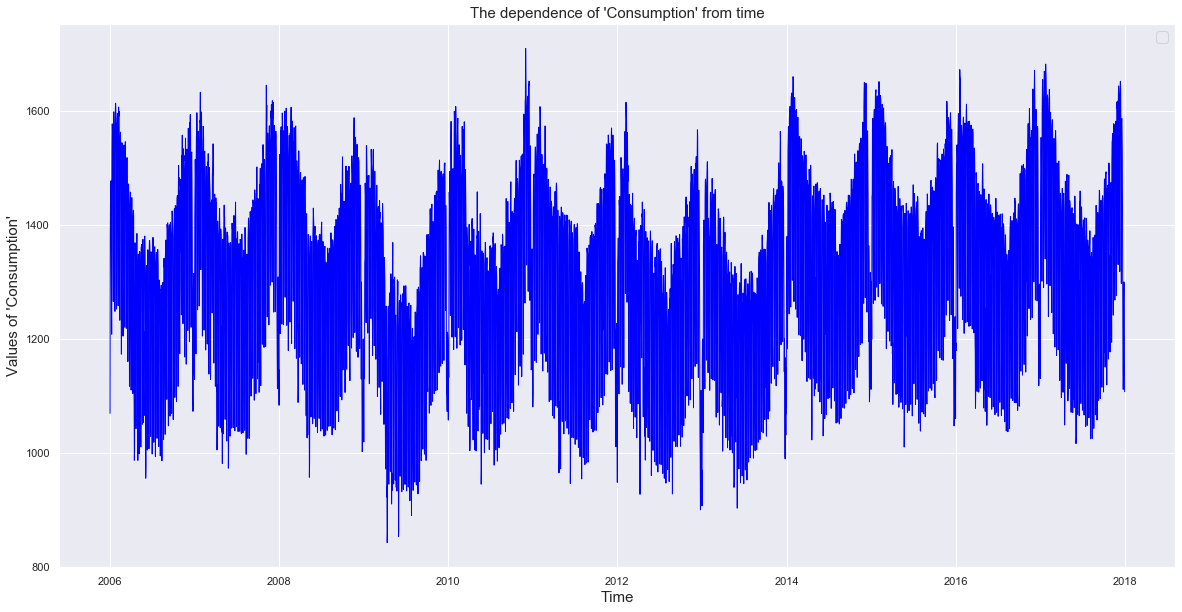

In [30]:
generator = AnomalyGenerator().read_data_from_file("opsd_germany_daily.csv",
                                                   "Date", 
                                                   type_of_time_column = "timeseries")
generator.show_data('Consumption')

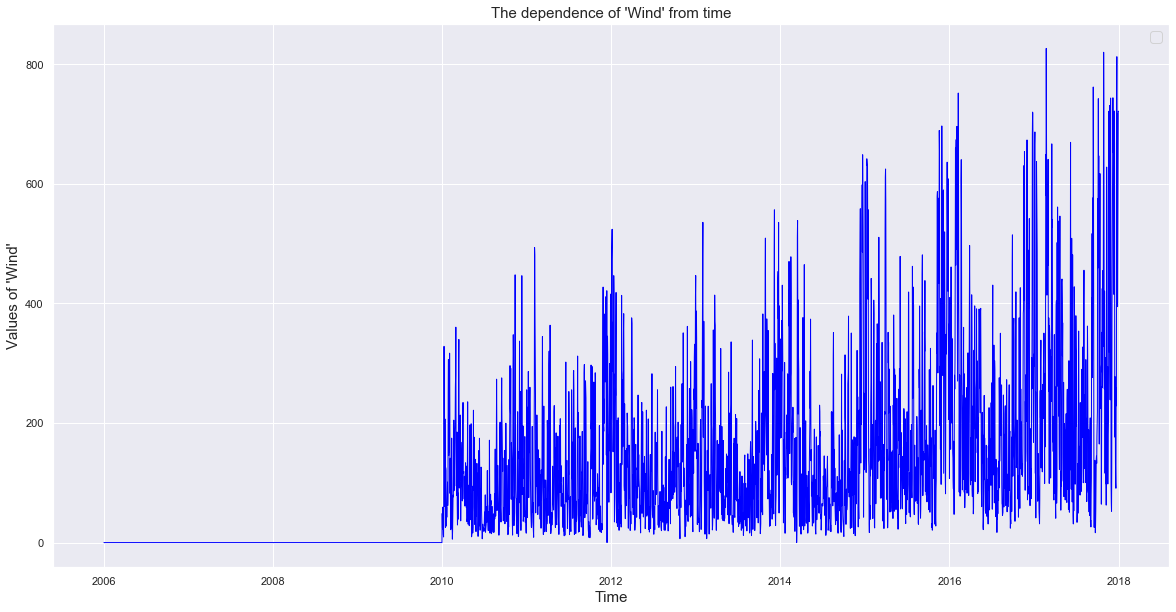

In [3]:
generator.show_data('Wind')

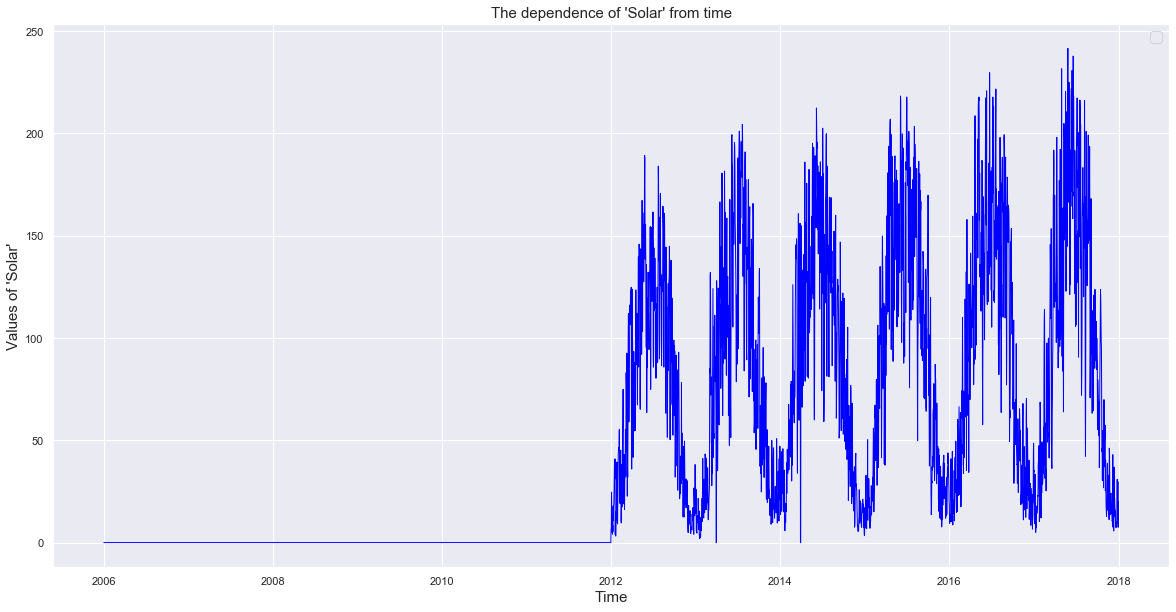

In [4]:
generator.show_data('Solar')

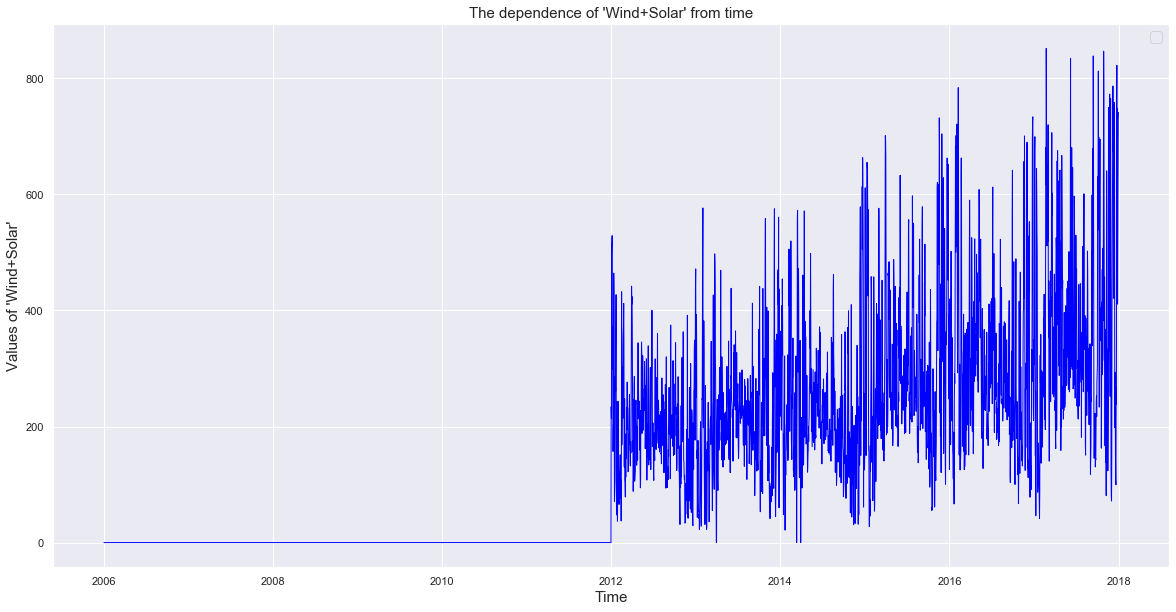

In [5]:
generator.show_data('Wind+Solar')

В начале значения столбцов `Wind`, `Wind+Solar`, `Solar` - `nan`, поэтому для адекватной работы с данными я кастую их к 0.


Теперь добавим аномалии к данным. Это происходит следующим образом: созадается словарик, где столбцам сопоставляется лист из возможных типов аномалий (Про каждый тип написано в `Readme`), а дальше в качестве параметра подается на вход функции `add_anomalies`, в которой также можно указать:

* процент аномальных точек

* количество аномалий, тогда в этом случае функция будет ориентироваться на этот параметр.

* минимальный размер окна аномалии (максимальный размер - в 2 раза больше минимально, выбирается рандомно)

* количество "нормальных" точек в начале, куда не будут добавлены аномалии, чтобы модель могла обучиться на нормальных данных (модели может нужно какое-то время, чтобы изначально обучиться, и предсказывать в это время аномалии она не сможет).

* минимальную дистанцию между аномалиями, в противном случае высчитывается автоматически

Из доп информации: модели запрещено добавлять в одном столбце аномалии типа новизны ближе, чем $0.33\ *\ $ размер датасета.

In [49]:
generator.reset() # clear dataset, if you have already apply outliers to data
anomaly_type = {'Wind': Anomaly.novelty}
generator.add_real_data_anomaly(start_index=1461,
                                anomaly_type=anomaly_type,
                                size=200)
anomaly_type = {'Solar': Anomaly.novelty}
generator.add_real_data_anomaly(start_index=2191,
                                anomaly_type=anomaly_type,
                                size=200)

[(1662, 1831), (2392, 4183)]


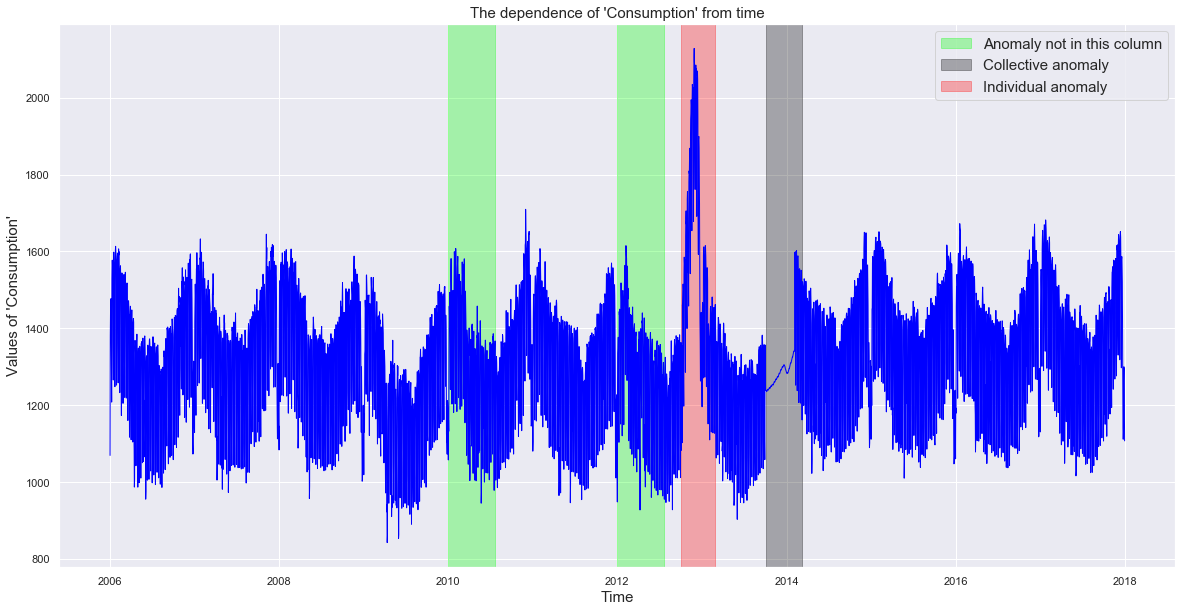

In [50]:
anomaly_types = {'Consumption': [Anomaly.collective,
                                 Anomaly.individual,
                                 Anomaly.shift]}

generator.generate_anomalies(anomaly_types, pct_of_outliers = 0.2, minsize = 100, 
                             random_state = 4, length_of_normal_data_in_start = 1501)
generator.show_data('Consumption')

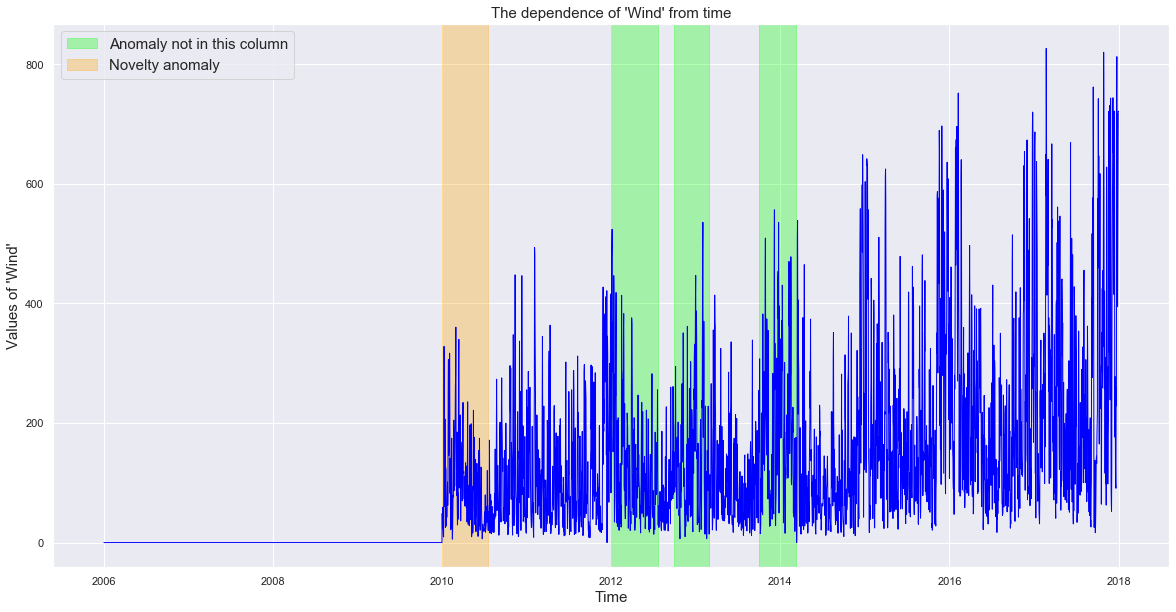

In [8]:
generator.show_data('Wind')

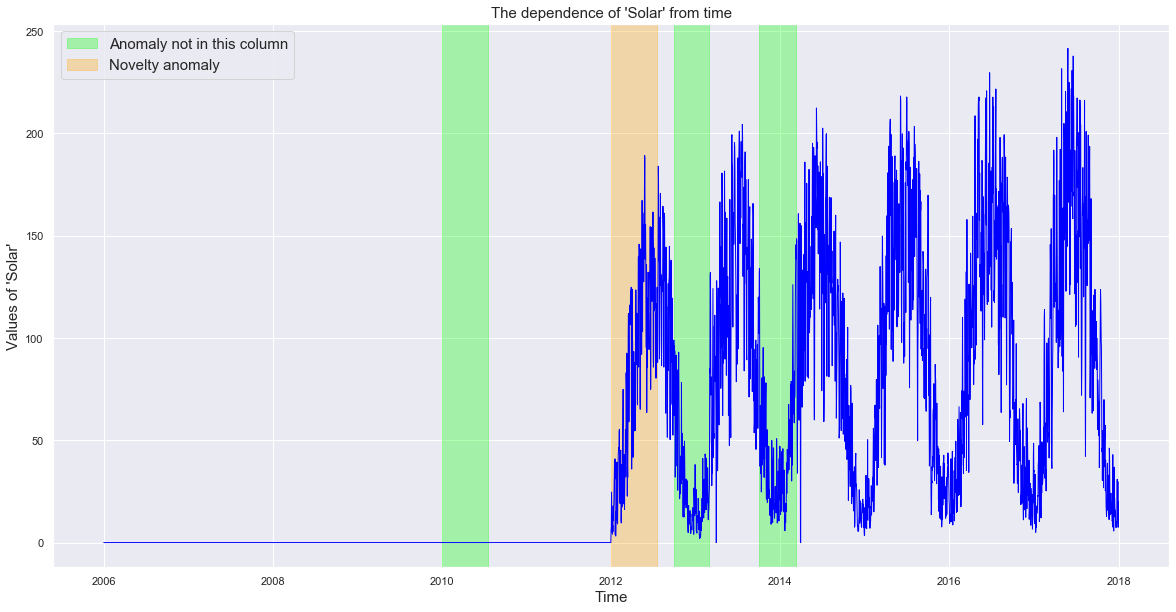

In [9]:
generator.show_data('Solar')

Теперь запустим раннер модели. В него надо пердать модель предсказания, генератор (уже добавивший аномалии), и параметры модели. Также можно передать `alpha` - минимальное p-value для отвержения гипотезы о том, что точка нормальна (изначально равна 0.99). 

Внутри себя генератор по циклу выдает одно новое значение для модели, а модель в этот же момент предсказывает, аномальна ли точка, или нет (а точнее возращает pvalue для новой точки).

Возвращает массив pvalue и бинарный массив ответ, является ли точка аномальной.

## RobustRandomCutForest

In [10]:
energy_robast_forest_pvals, energy_robast_forest_predicted_anomaly_indexes = \
run_model_on_generator(RobustRandomCutForest, 
                       generator, train_size=700, alpha=0.99)

/Users/lunin-dv/Desktop/Курсач?/github/Anomaly/RobustRandomCutForest.py:67: RuntimeWarning: invalid value encountered in double_scalars
  pvalue = 2 * sps.norm(0, 1).cdf(abs(small_mu - big_mu) / sigma) - 1


/Users/lunin-dv/Desktop/Курсач?/github/Anomaly/AnomalyModelRunner.py:23: RuntimeWarning: invalid value encountered in greater
  return pvals, np.where(pvals > alpha)[0]


Визуализируем результат. Передаем столбец, имя модели и предсказанные pvalue. Также  можно снова указать `alpha` - минимальное p-value.

Построит график с данными и пометит на них аномальные точки. А также нарисует график значений pvalue в каждой точке.

/Users/lunin-dv/Desktop/Курсач?/github/Anomaly/AnomalyModelRunner.py:35: RuntimeWarning: invalid value encountered in greater
  generator.show_data(column_name, predicted_anomaly_points=np.where(pvalues > alpha)[0])


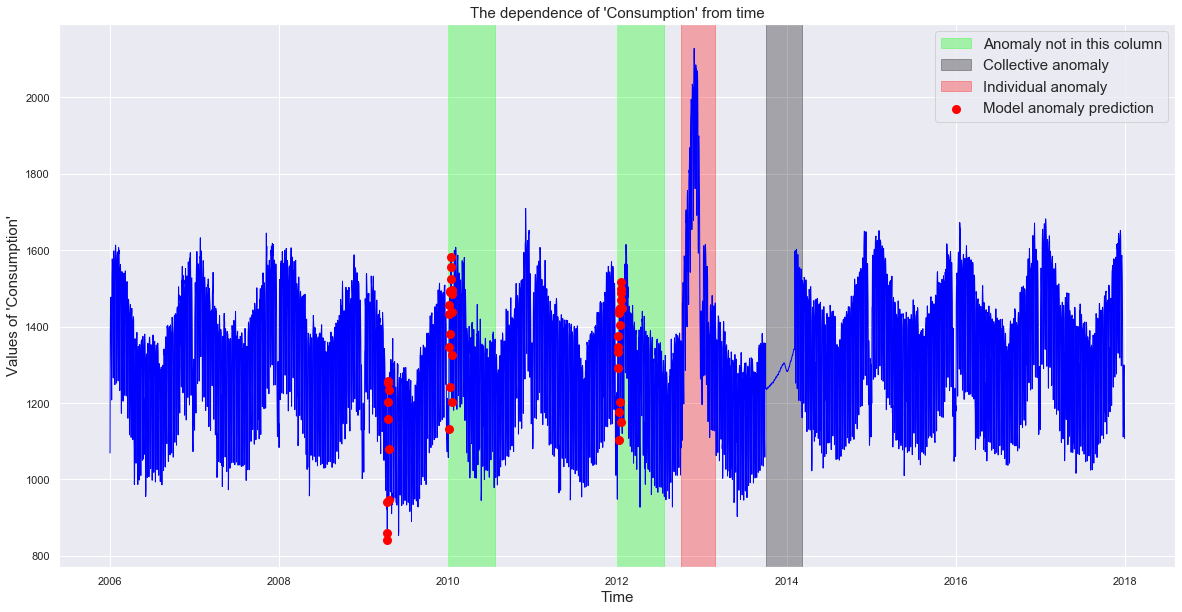

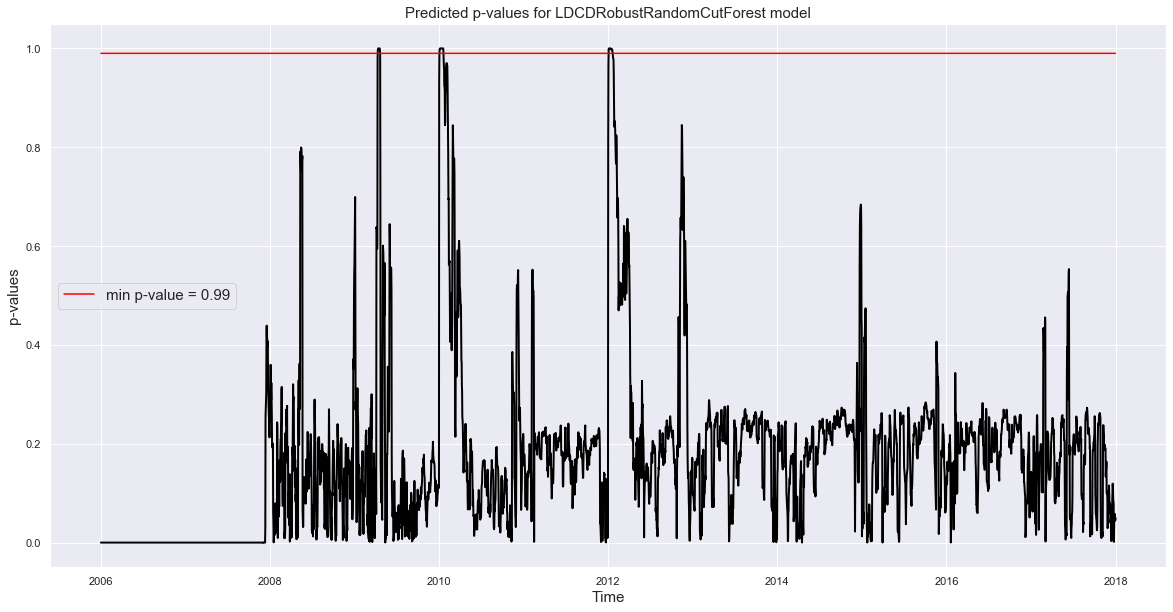

In [11]:
show_model_results('Consumption', "LDCDRobustRandomCutForest", 
                   generator, energy_robast_forest_pvals, alpha=0.99)

Как видно, модель сносно отработала, нашла лишние аномалии, и не выделила все аномалии, которые были добавлены генератором.

Также для удобства можно показать окно с центром в аномалии с порядковым индексом i (нумерация с 0, покажет i аномалию от начала).

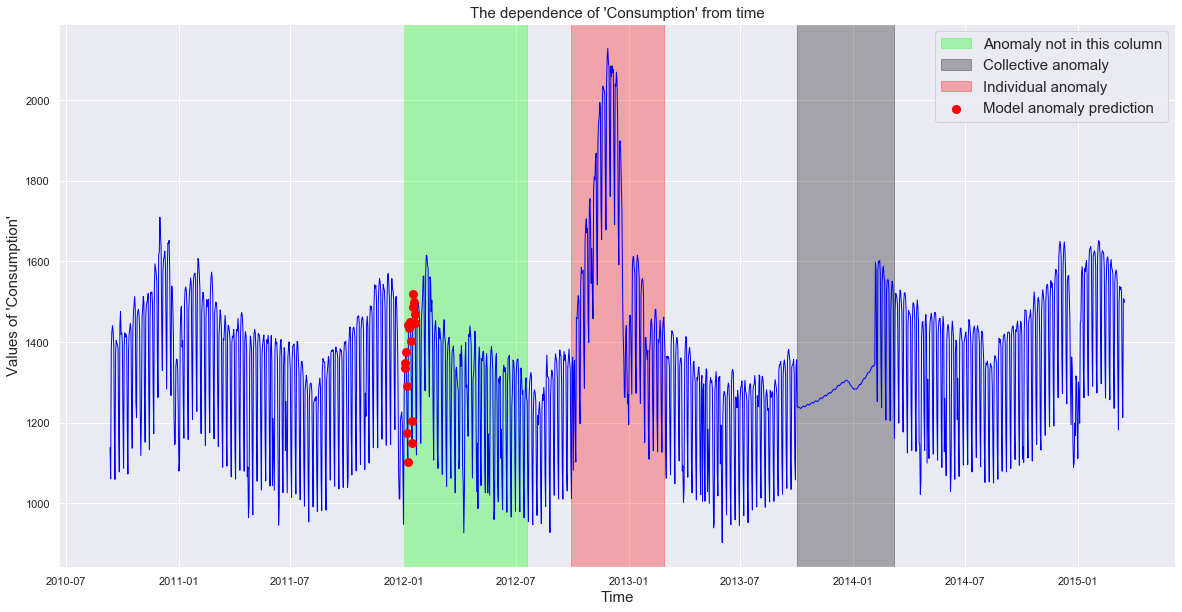

In [12]:
generator.show_anomaly('Consumption', 2, 
    predicted_anomaly_points=energy_robast_forest_predicted_anomaly_indexes)

Как видим, это явная аномалия, которую модель не заметила.

## LSTM model

/Users/lunin-dv/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 100])) that is different to the input size (torch.Size([1, 100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


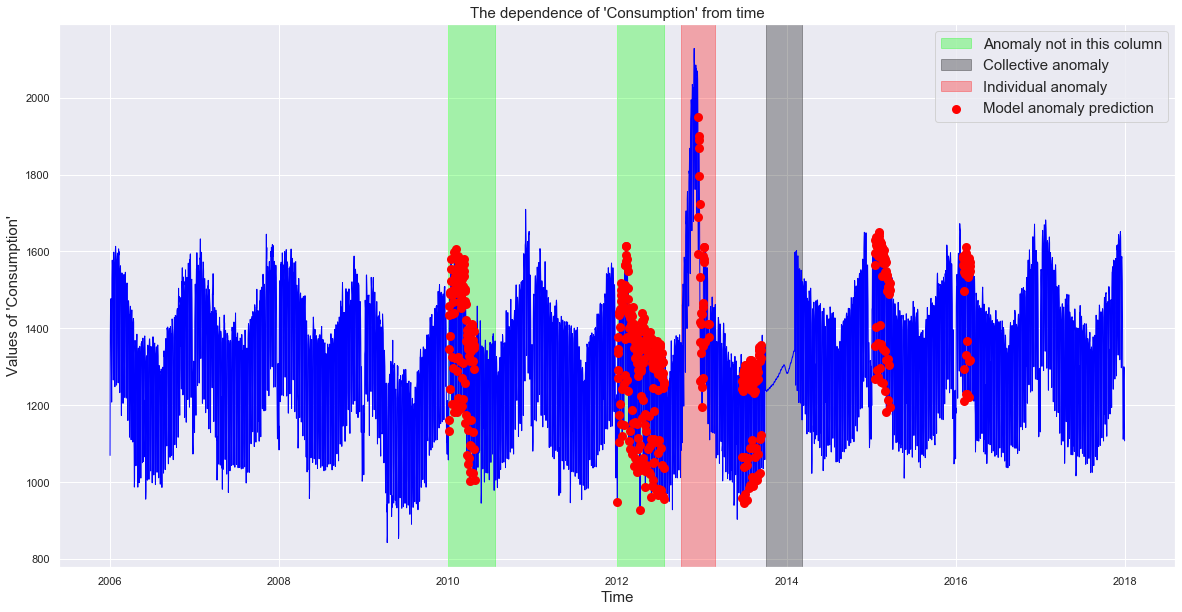

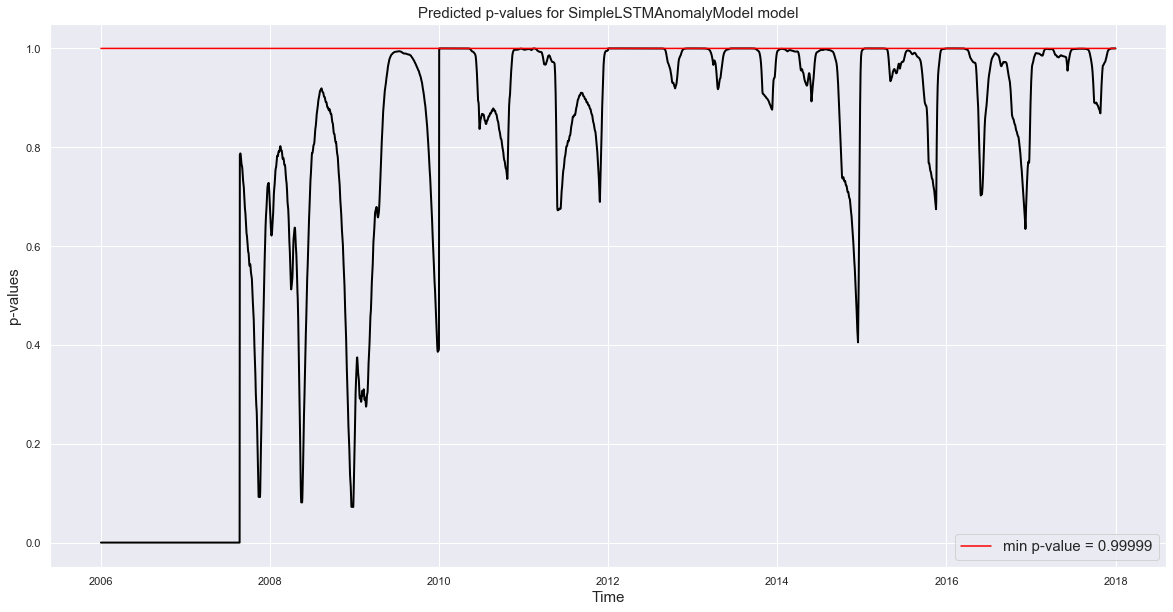

In [13]:
alpha = 1 - 10 ** (-5)
energy_lstm_pvals, energy_lstm_predicted_anomaly_indexes = \
run_model_on_generator(SimpleLSTMAnomalyModel, 
                       generator, alpha=alpha, in_out_size=4, hidden_lstm_size=8)

show_model_results('Consumption', "SimpleLSTMAnomalyModel", 
                   generator, energy_lstm_pvals, alpha=alpha)

## KNN Model

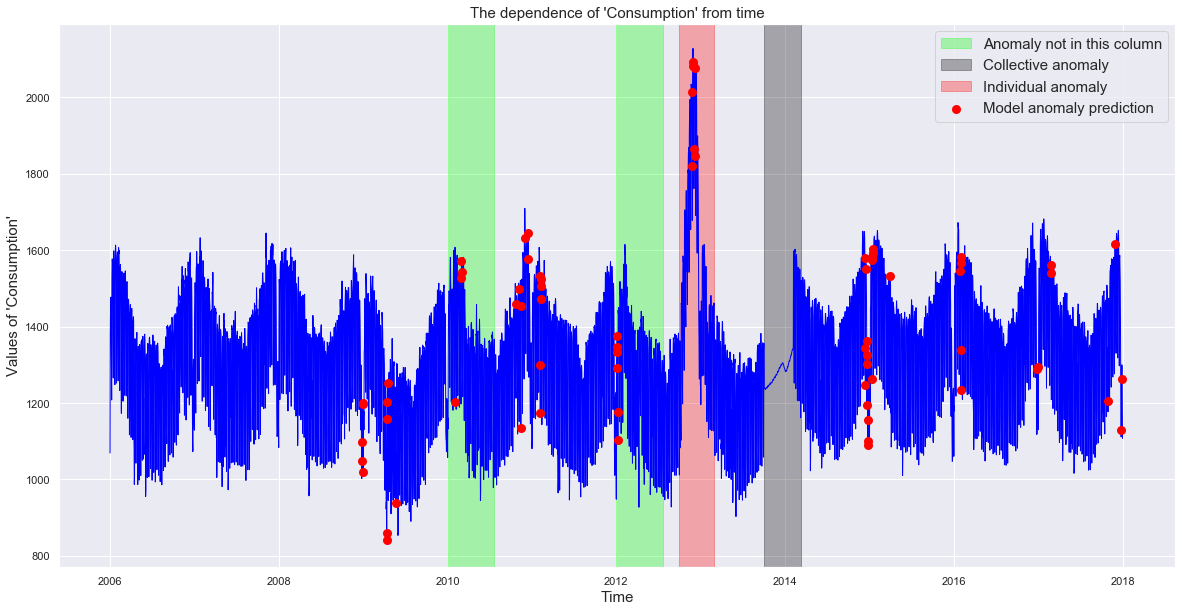

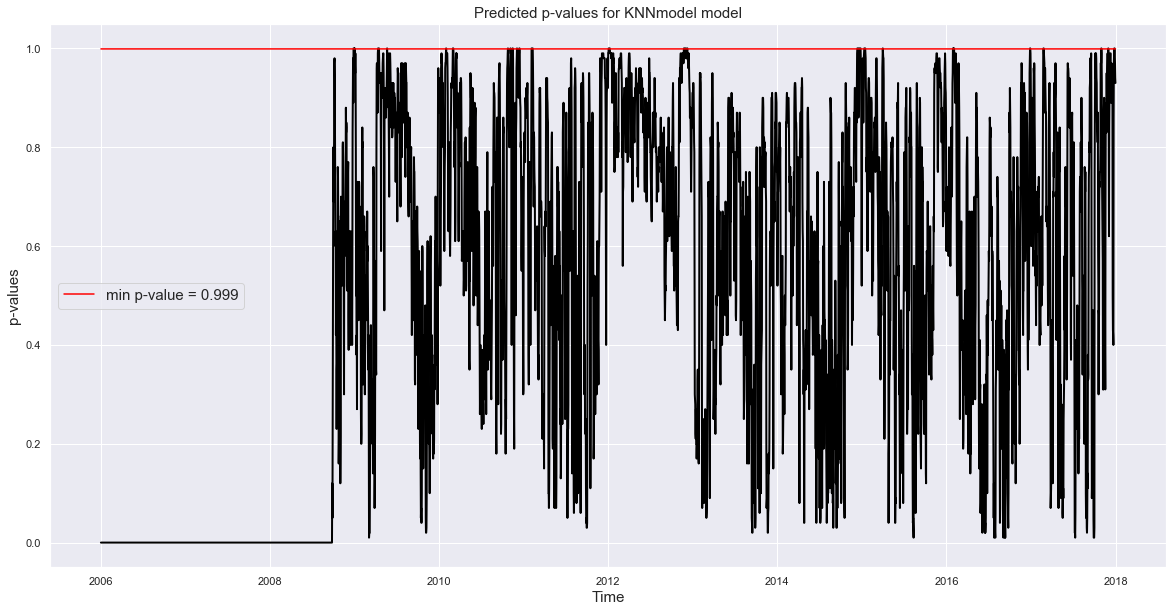

In [14]:
energy_knn_pvals, energy_knn_anomaly_indexes = \
run_model_on_generator(KNNmodel, 
                       generator, dimension = generator.get_data_dimension())
show_model_results('Consumption', "KNNmodel", 
                   generator, energy_knn_pvals, alpha=0.999)

##  Fourier Model

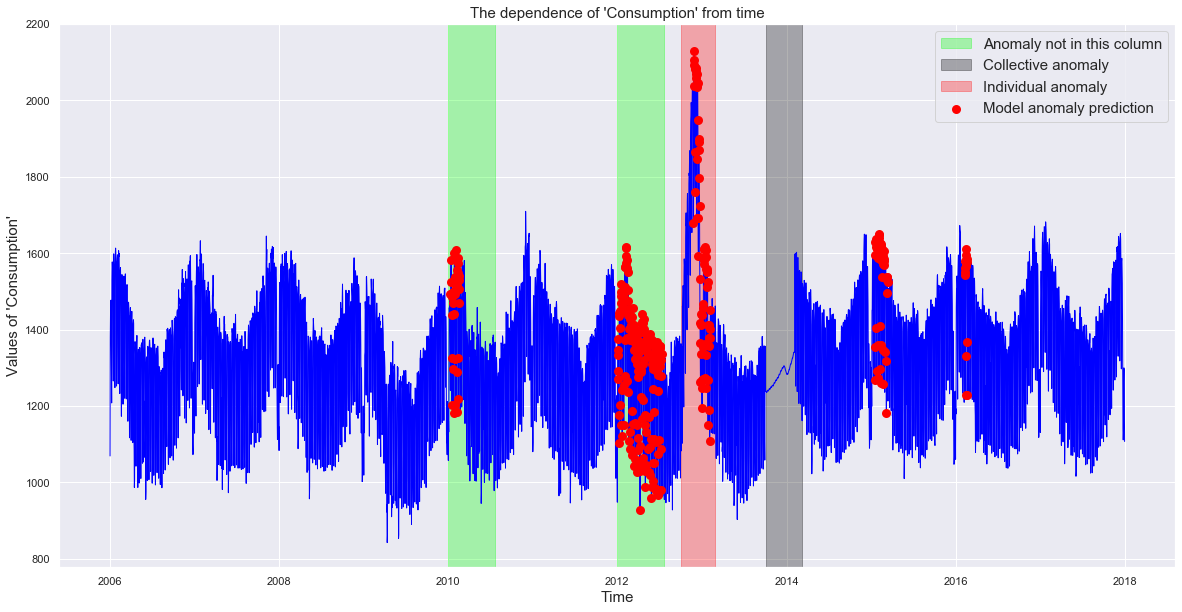

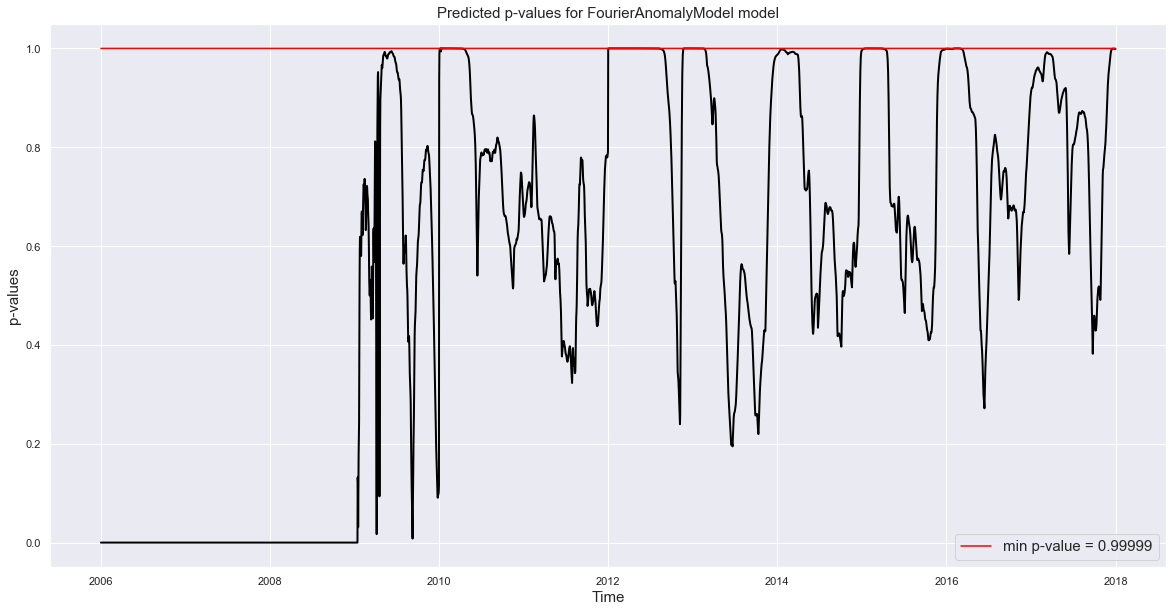

In [16]:
alpha = 1 - 10 ** (-5)
energy_fft_pvals, energy_fft_anomaly_indexes = \
run_model_on_generator(FourierAnomalyModel, 
                       generator, dimension=4, alpha=alpha)

show_model_results('Consumption', "FourierAnomalyModel", 
                   generator, energy_fft_pvals, alpha=alpha)

## Artificial dataset

Теперь посмотрим, как модель справляется на искусственном датасете с одним параметром.

In [17]:
size = 10000
data = np.arange(0, size)
x = 50 * np.sin(0.005 * data) + sps.norm(0, 50).rvs(size) + 0.05 * data
data = np.concatenate([data.reshape(-1, 1), x.reshape(-1, 1)], axis = 1)
df = pd.DataFrame(data, columns = ['Time', 'X'])

Проделаем те же действия, что и в прошлый раз.

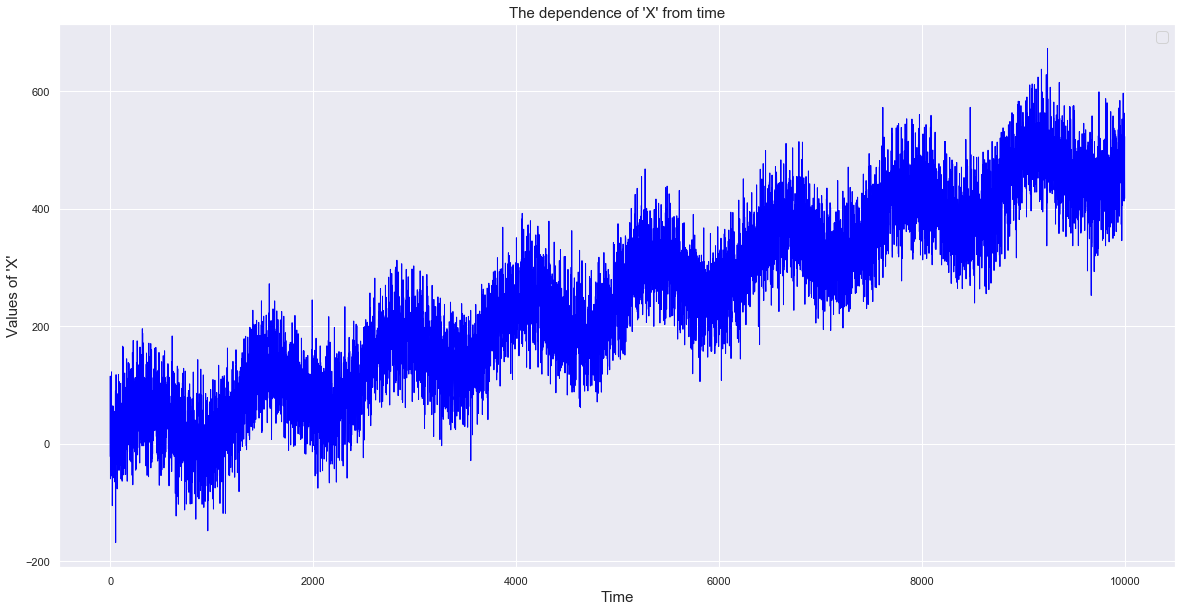

In [18]:
artificial_generator = AnomalyGenerator().read_data_from_pd_dataframe(df, "Time", 
                                                   type_of_time_column = "float")
artificial_generator.show_data('X')

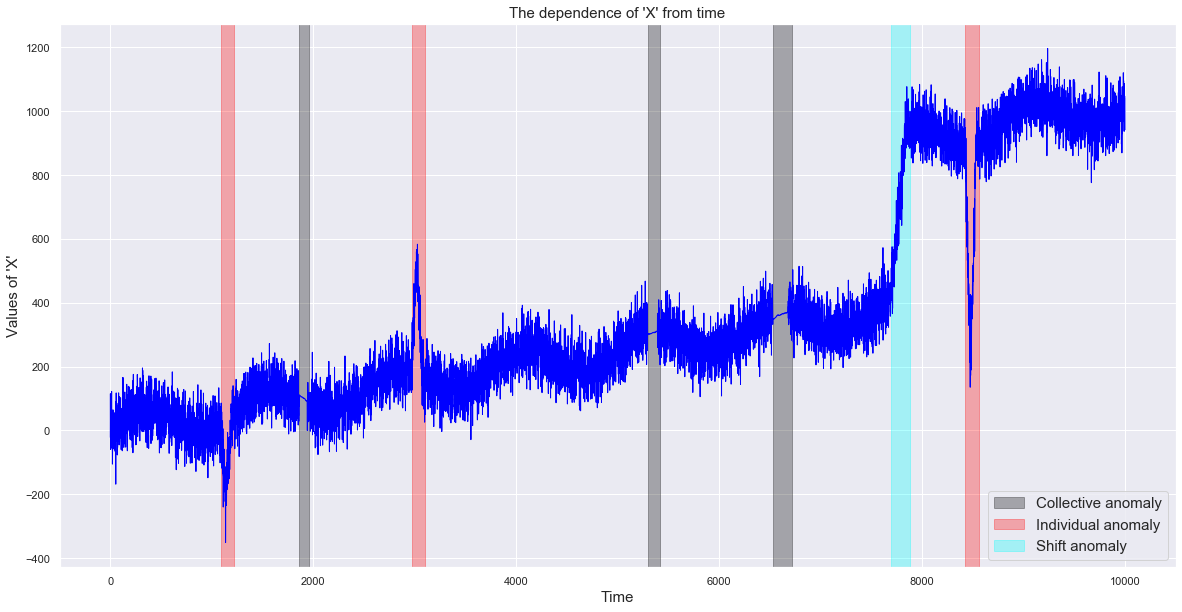

In [19]:
anomaly_types = {'X': [Anomaly.collective,
                        Anomaly.individual,
                        Anomaly.shift]}
artificial_generator.generate_anomalies(anomaly_types, pct_of_outliers = 0.15, minsize = 100, 
                            random_state = 42, length_of_normal_data_in_start = 1001)
artificial_generator.show_data('X')

In [20]:
artificial_robast_forest_pvals, artificial_robast_forest_predicted_anomaly_indexes = \
run_model_on_generator(RobustRandomCutForest, 
                       artificial_generator, train_size=1000)

/Users/lunin-dv/Desktop/Курсач?/github/Anomaly/RobustRandomCutForest.py:67: RuntimeWarning: invalid value encountered in double_scalars
  pvalue = 2 * sps.norm(0, 1).cdf(abs(small_mu - big_mu) / sigma) - 1


/Users/lunin-dv/Desktop/Курсач?/github/Anomaly/AnomalyModelRunner.py:23: RuntimeWarning: invalid value encountered in greater
  return pvals, np.where(pvals > alpha)[0]


/Users/lunin-dv/Desktop/Курсач?/github/Anomaly/AnomalyModelRunner.py:35: RuntimeWarning: invalid value encountered in greater
  generator.show_data(column_name, predicted_anomaly_points=np.where(pvalues > alpha)[0])


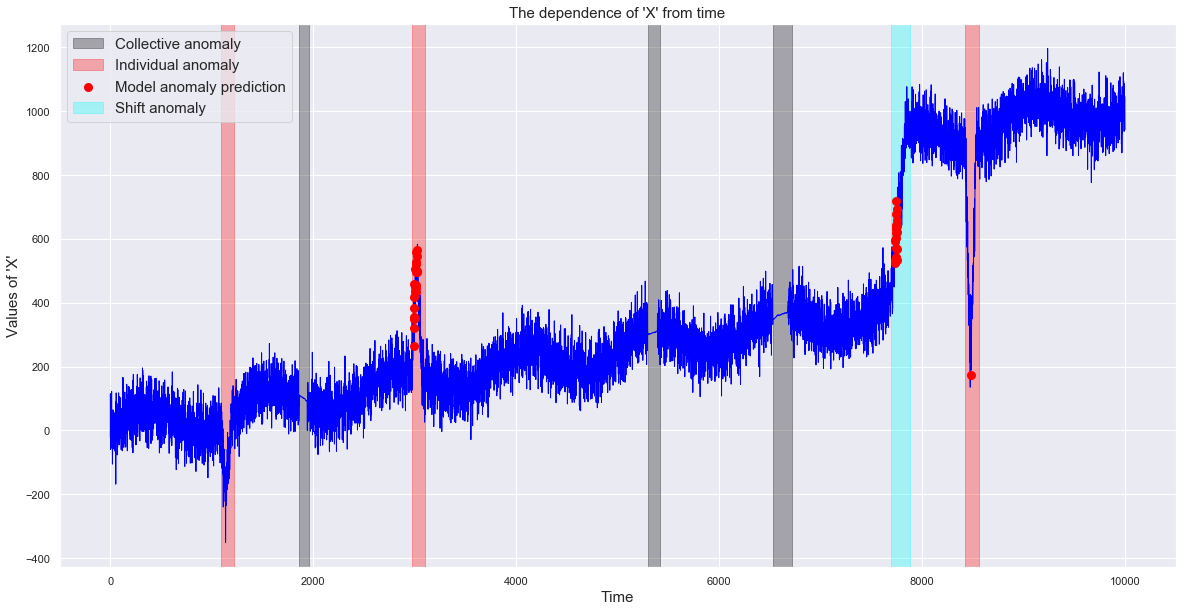

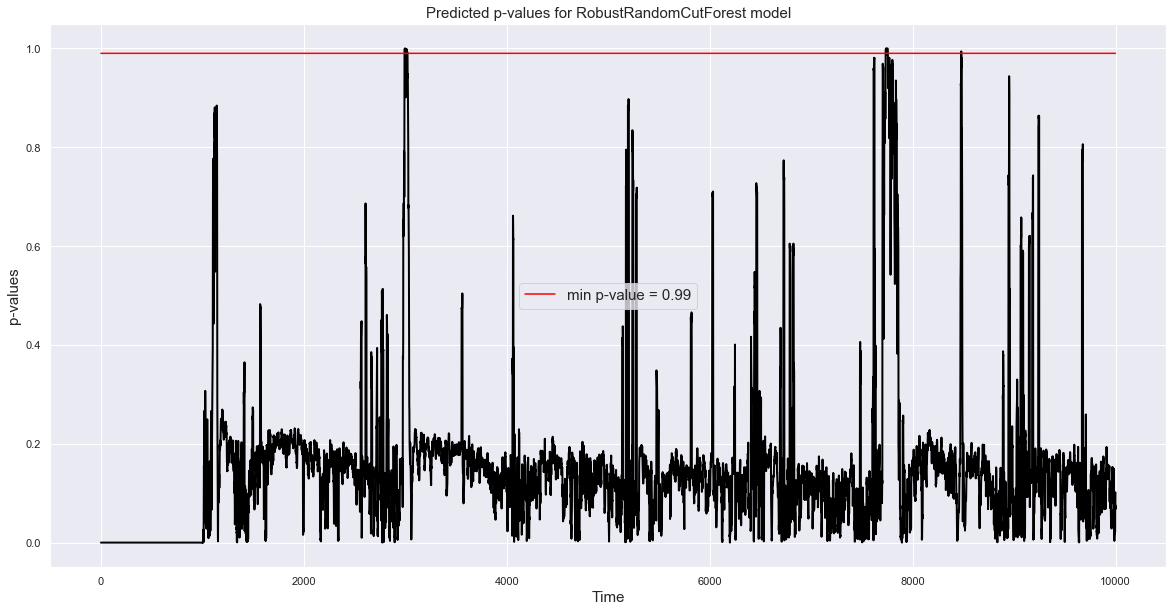

In [21]:
show_model_results('X', "RobustRandomCutForest", 
                   artificial_generator, artificial_robast_forest_pvals)

Как видно, модель несколько лишних точек, а также не отметила все групповые аномалии, а значит, получился не слишком хороший генератор аномалий.

In [22]:
alpha = 1 - 10 ** (-5)
artificial_lstm_pvals, artificial_lstm_predicted_anomaly_indexes = \
run_model_on_generator(SimpleLSTMAnomalyModel, 
                       artificial_generator, alpha=alpha, in_out_size=1)

/Users/lunin-dv/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 100])) that is different to the input size (torch.Size([1, 100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


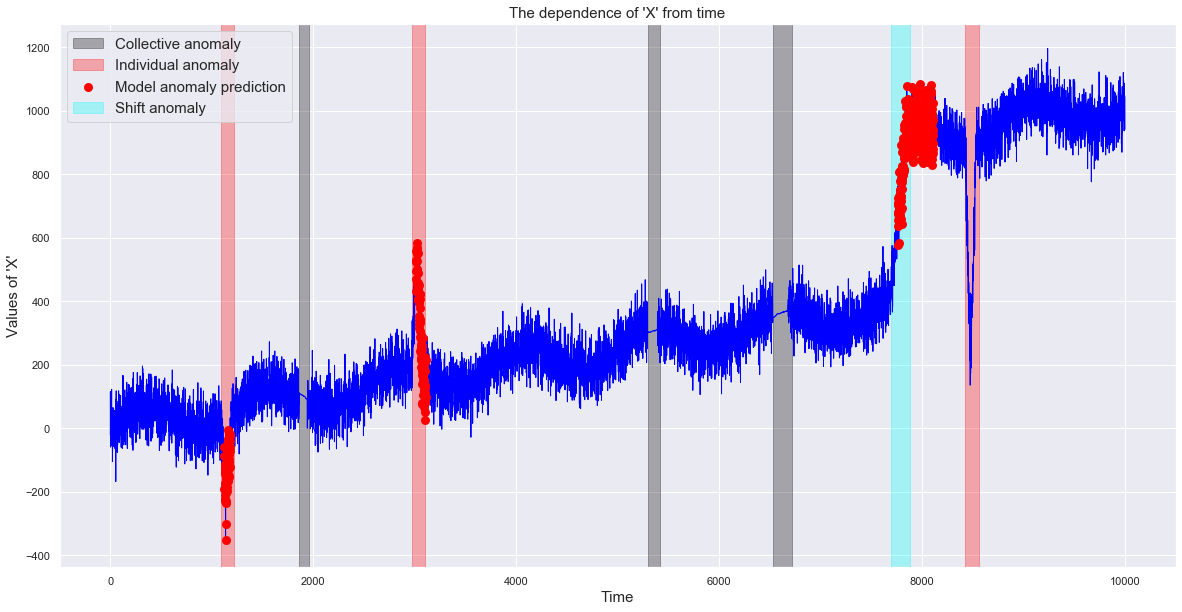

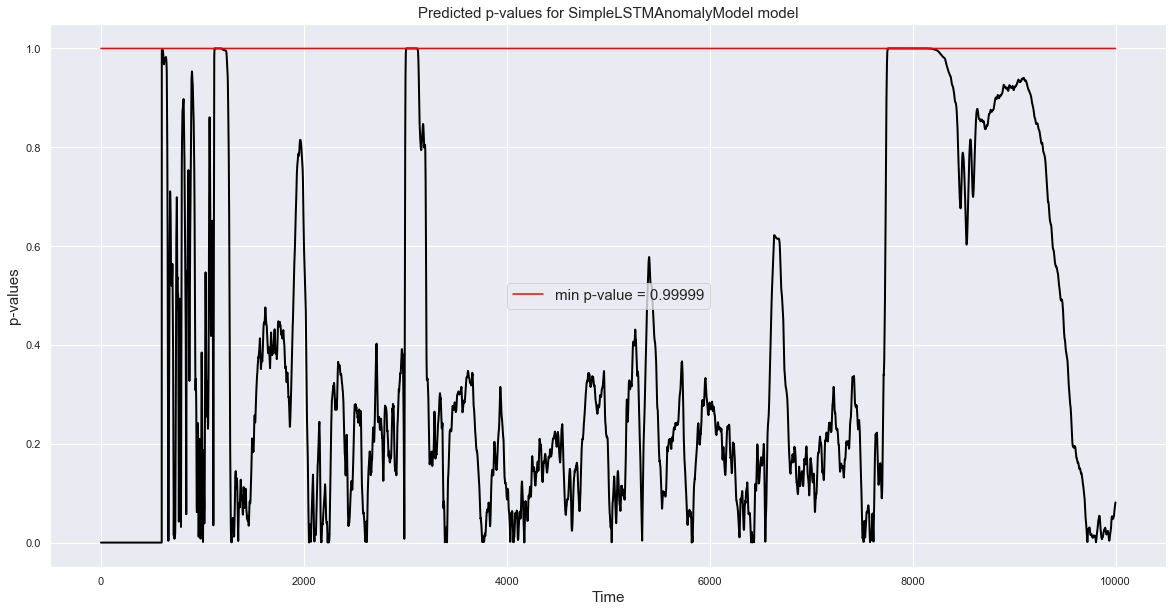

In [23]:
show_model_results('X', "SimpleLSTMAnomalyModel", 
                   artificial_generator, artificial_lstm_pvals, alpha=alpha)

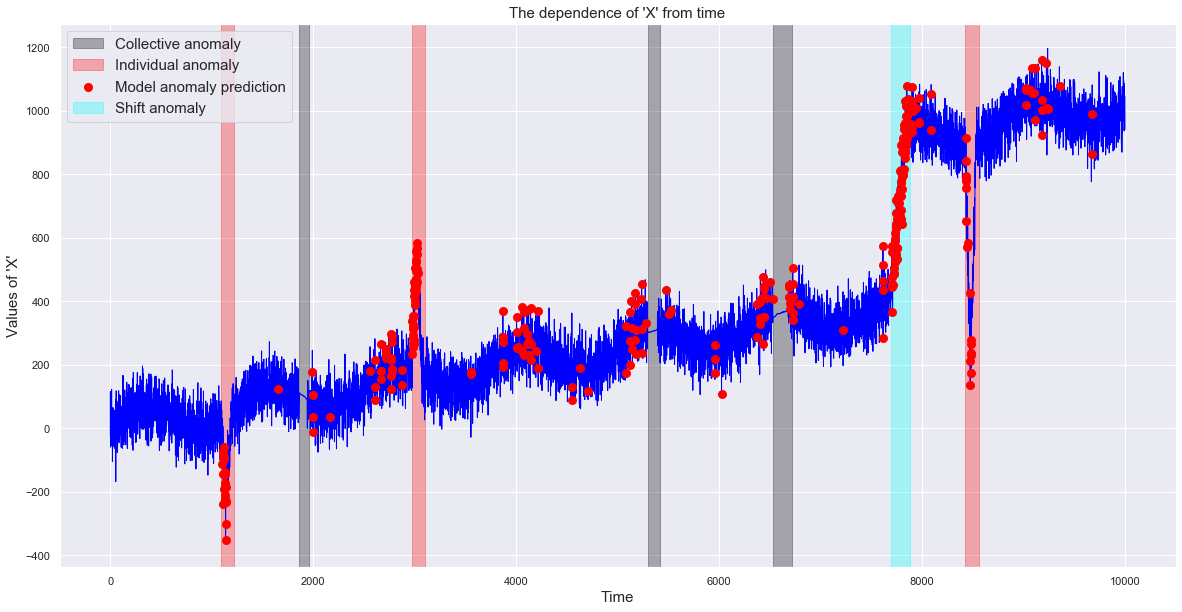

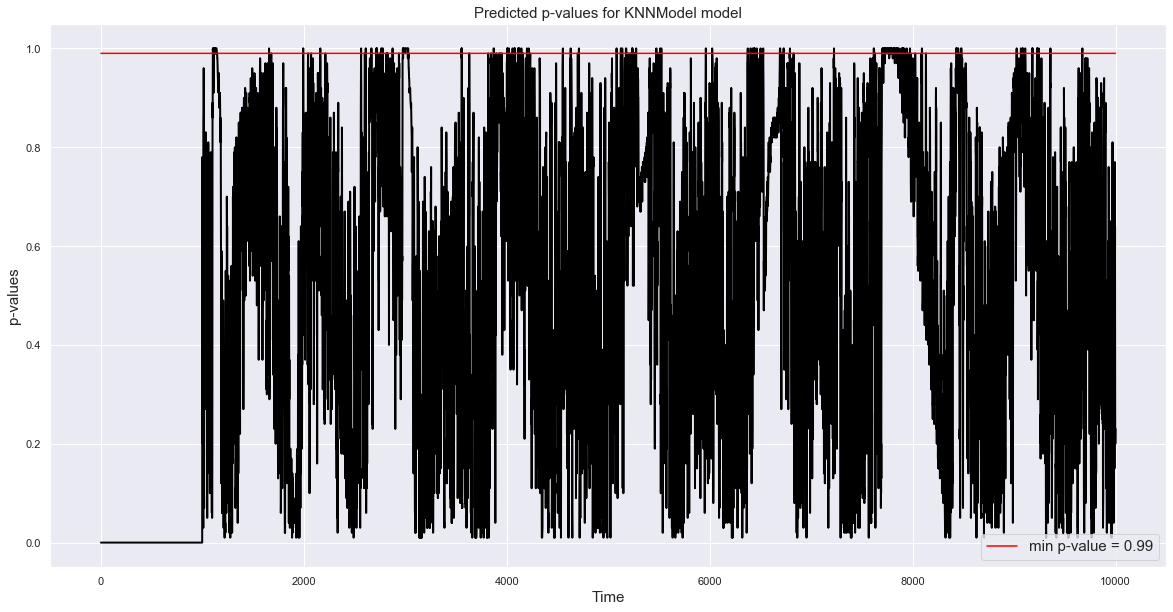

In [24]:
artificial_knn_pvals, artificial_knn_anomaly_indexes = \
run_model_on_generator(KNNmodel, 
                       artificial_generator, dimension = 1)

show_model_results('X', "KNNModel", 
                   artificial_generator, artificial_knn_pvals)

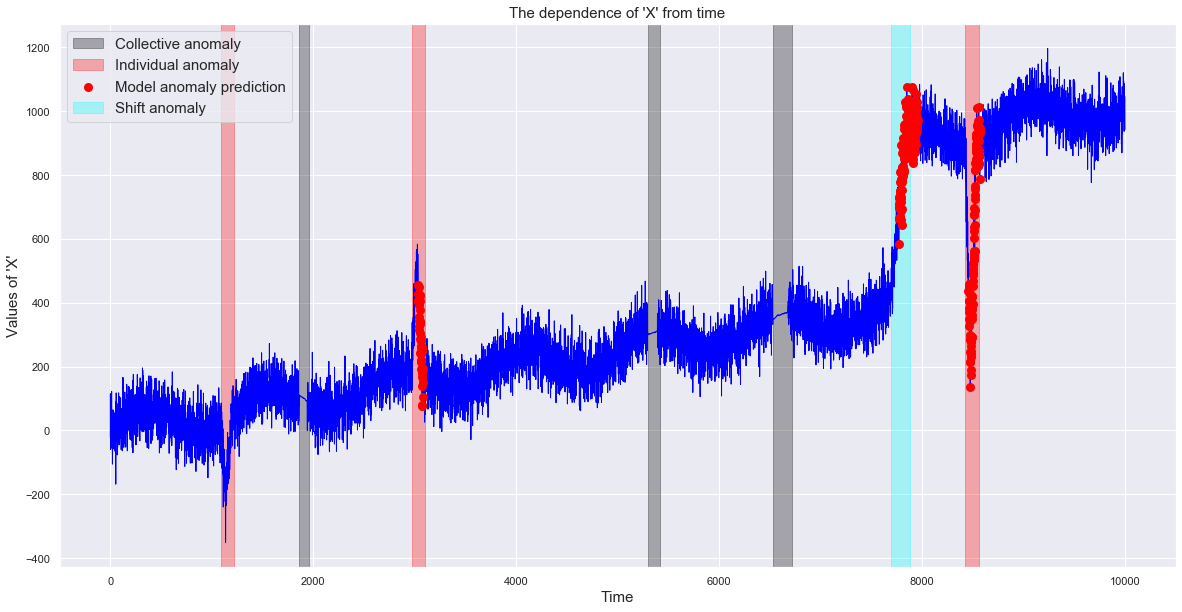

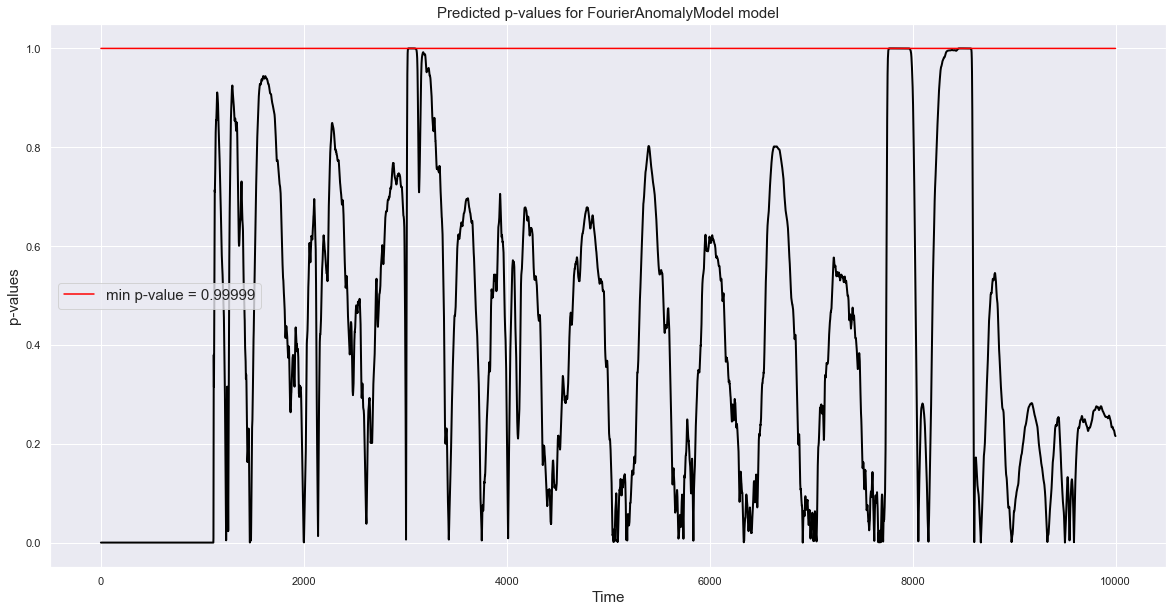

In [31]:
alpha = 1 - 10 ** (-5)
artificial_fft_pvals, artificial_fft_anomaly_indexes = \
run_model_on_generator(FourierAnomalyModel, 
                       artificial_generator, dimension=1, alpha=alpha)

show_model_results('X', "FourierAnomalyModel", 
                   artificial_generator, artificial_fft_pvals, alpha=alpha)

Теперь запустим nab scorer

In [42]:
scorer = NAB(a_fp = -0.01)

In [43]:
scorer.score([generator.anomalies, artificial_generator.anomalies], 
             [energy_robast_forest_predicted_anomaly_indexes,
              artificial_robast_forest_predicted_anomaly_indexes])

44.88320390503176

In [44]:
scorer.score([generator.anomalies, artificial_generator.anomalies], 
             [energy_lstm_predicted_anomaly_indexes, 
              artificial_lstm_predicted_anomaly_indexes])

36.60764941844264

In [45]:
scorer.score([generator.anomalies, artificial_generator.anomalies], 
             [energy_knn_anomaly_indexes,
              artificial_knn_anomaly_indexes])

62.20739471514314

In [46]:
scorer.score([generator.anomalies, artificial_generator.anomalies], 
             [energy_fft_anomaly_indexes,
              artificial_fft_anomaly_indexes])

49.16828452697683